In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary
import numpy as np

In [0]:
transform = transforms.Compose([ # 우리의 데이터를 전처리하는 패키지. 
    transforms.ToTensor(), # 데이터 타입을 Tensor 형태로 변경. 
    transforms.Normalize((0.5, ), (0.5, )), # Normalize a tensor image with mean(0.5) and standard deviation(0.5).
])

In [0]:
batch_size = 128 # 배치 사이즈.
z_dim = 100 # 은닉 노드 숫자.

In [0]:
# MNIST 데이터를 불러옴. 
database = dataset.MNIST('mnist', train = True, download = True, transform = transform)
#Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = torch.utils.data.DataLoader(
    #dataset.MNIST('mnist', train = True, download = True, transform = transform),
    database,
    batch_size = batch_size,
    shuffle = True
)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
 for i, data in enumerate(train_loader):
     print ("batch id =" + str(i) )
     print (data[0])
     print (data[1])

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# CUDA 장치 객체(device object)로 GPU 상에 직접적으로 tensor를 생성하거나, .to("device")를 사용하면 된다. 

In [0]:
# generator model 생성.
# __init__, forward funtion으로 구성됨. 
class Generator_model(nn.Module): # 사용자 정의 nn 모듈. 
    def __init__(self, z_dim):
        super().__init__()
        self.fc = nn.Linear(z_dim, 256 * 7 * 7)
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 256, 7, 7)
        return self.gen(x)

In [0]:
generator = Generator_model(z_dim).to(device)
# .to method를 통해 Tensor를 어떠한 장치로도 옮길 수 있다. 

In [0]:
generator.apply(weights_init)

Generator_model(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (gen): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

In [0]:
summary(generator, (100, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,266,944
   ConvTranspose2d-2          [-1, 128, 14, 14]         524,416
       BatchNorm2d-3          [-1, 128, 14, 14]             256
         LeakyReLU-4          [-1, 128, 14, 14]               0
   ConvTranspose2d-5           [-1, 64, 14, 14]          73,792
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         LeakyReLU-7           [-1, 64, 14, 14]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]           1,025
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 1,866,561
Trainable params: 1,866,561
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.97
Params size (MB): 7.12
Estimated Total Size (MB): 8.09
---------------------------------------

In [0]:
# discriminator model 구성
# __init__, forward function으로 구성됨. 
class Discriminator_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01)
        )
        self.fc = nn.Linear(2048, 1)
    def forward(self, input):
        x = self.disc(input)
        return F.sigmoid(self.fc(x.view(-1, 2048)))

In [0]:
discriminator = Discriminator_model().to(device)

In [0]:
discriminator.apply(weights_init)

Discriminator_model(
  (disc): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [0]:
summary(discriminator, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
         LeakyReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
       BatchNorm2d-4             [-1, 64, 7, 7]             128
         LeakyReLU-5             [-1, 64, 7, 7]               0
            Conv2d-6            [-1, 128, 4, 4]          73,856
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Linear-9                    [-1, 1]           2,049
Total params: 95,105
Trainable params: 95,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.36
Estimated Total Size (MB): 0.58
---------------------------------------------

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
criterion = nn.BCELoss()
# 손실함수 지정 = Binary Cross Entropy Loss function. 

In [0]:
# create a batch (whose size 64) of fixed noise vectors (z_dim=100)
fixed_noise = torch.randn(64, z_dim, device=device)

In [0]:
# 최적화 함수 지정. adam을 사용. 
# model.parameters()를 통해 model의 parameter들을 할당함. 
doptimizer = optim.Adam(discriminator.parameters())
goptimizer = optim.Adam(generator.parameters())

In [0]:
# 라벨링. 
real_label, fake_label = 1, 0

In [0]:
image_list = []
g_losses = []
d_losses = []
iterations = 0
num_epochs = 50

In [0]:
# train.
for epoch in range(num_epochs):
    print(f'Epoch : | {epoch+1:03} / {num_epochs:03} |')
    for i, data in enumerate(train_loader):
        
        discriminator.zero_grad() # zero_grad()는 variable들에 대한 모든 변화도를 0으로 만듦. 
        
        real_images = data[0].to(device) # real_images: size = (128,1,28,28)
      
        size = real_images.size(0) # size = 128 = batch size       
        label = torch.full((size,), real_label, device=device)  # real_label =1    
        d_output = discriminator(real_images).view(-1)
        derror_real = criterion(d_output, label)       

        derror_real.backward() # 역전파 단계 실행. 모델의 variable들에 대한 손실의 변화도를 계산함. 
        
        noise = torch.randn(size, z_dim, device=device) # noise shape = (128, 100)
        fake_images = generator(noise) # fake_images: shape = (128,1,28,28)
        label.fill_(0)  #_: in-place-operation
        d_output = discriminator(fake_images.detach()).view(-1)        
     
        derror_fake = criterion(d_output, label)         
        derror_fake.backward()
        
        derror_total = derror_real + derror_fake
        doptimizer.step() # 가중치 갱신. 
        
        generator.zero_grad()
        #label.fill_(real_images) #_: in-place-operation; the same as label.fill_(1)
        label.fill_(1)            # why is the label for the fake-image is one rather than zero?
        d_output = discriminator(fake_images).view(-1)
        gerror = criterion(d_output, label)
        gerror.backward()
        
        goptimizer.step()
        
        if i % 50 == 0: # for every 50th i
            print(f'| {i:03} / {len(train_loader):03} | G Loss: {gerror.item():.3f} | D Loss: {derror_total.item():.3f} |')
            g_losses.append(gerror.item())
            d_losses.append(derror_total.item())
            
        if (iterations % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad(): # check if the generator has been improved from the same fixed_noise vector
                fake_images = generator(fixed_noise).detach().cpu()
            image_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
        iterations += 1

Epoch : | 001 / 050 |
| 000 / 469 | G Loss: 2.497 | D Loss: 1.278 |


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


| 050 / 469 | G Loss: 2.733 | D Loss: 0.445 |
| 100 / 469 | G Loss: 2.278 | D Loss: 0.321 |
| 150 / 469 | G Loss: 2.025 | D Loss: 1.075 |
| 200 / 469 | G Loss: 1.806 | D Loss: 1.380 |
| 250 / 469 | G Loss: 2.641 | D Loss: 0.414 |
| 300 / 469 | G Loss: 4.893 | D Loss: 0.094 |
| 350 / 469 | G Loss: 2.440 | D Loss: 0.325 |
| 400 / 469 | G Loss: 4.152 | D Loss: 0.120 |
| 450 / 469 | G Loss: 3.775 | D Loss: 0.144 |
Epoch : | 002 / 050 |
| 000 / 469 | G Loss: 5.638 | D Loss: 0.099 |
| 050 / 469 | G Loss: 1.201 | D Loss: 0.354 |
| 100 / 469 | G Loss: 3.397 | D Loss: 0.187 |
| 150 / 469 | G Loss: 4.795 | D Loss: 0.107 |
| 200 / 469 | G Loss: 5.701 | D Loss: 0.113 |
| 250 / 469 | G Loss: 4.438 | D Loss: 0.085 |
| 300 / 469 | G Loss: 5.391 | D Loss: 0.050 |
| 350 / 469 | G Loss: 4.430 | D Loss: 0.099 |
| 400 / 469 | G Loss: 4.306 | D Loss: 0.225 |
| 450 / 469 | G Loss: 4.283 | D Loss: 0.086 |
Epoch : | 003 / 050 |
| 000 / 469 | G Loss: 6.155 | D Loss: 0.039 |
| 050 / 469 | G Loss: 3.974 | D Loss

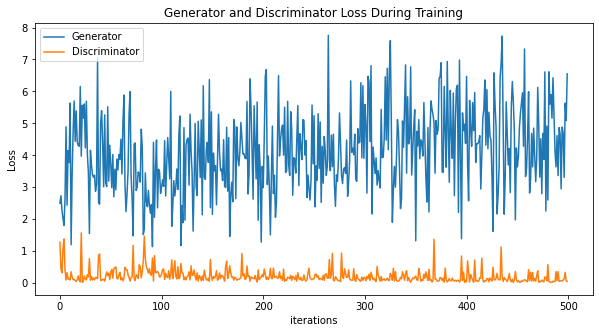

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

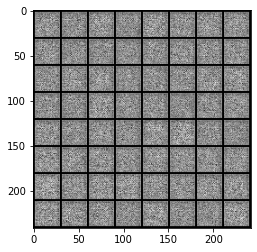

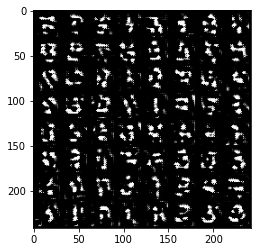

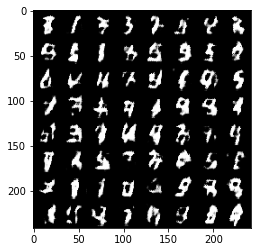

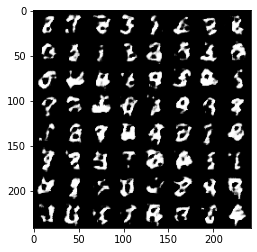

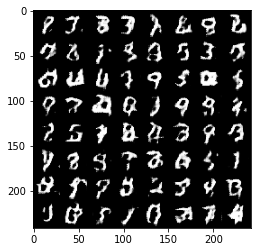

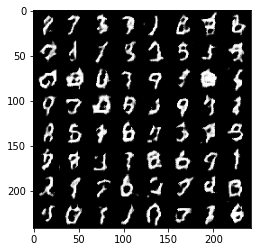

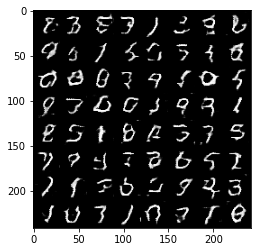

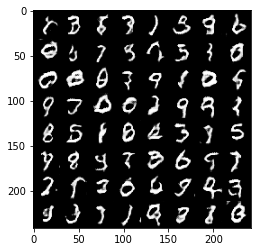

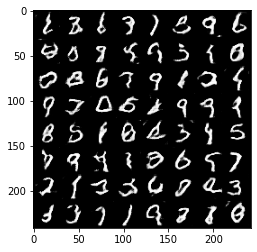

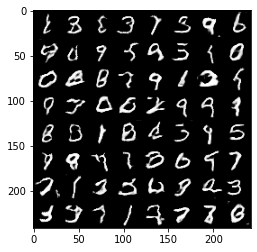

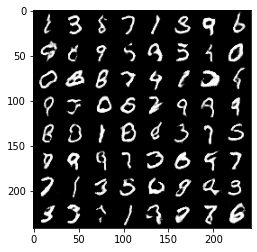

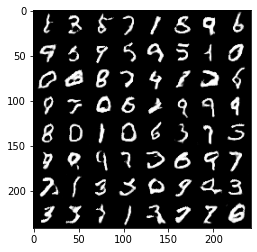

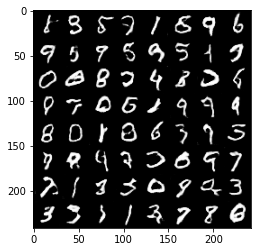

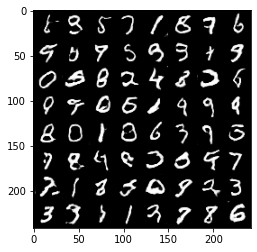

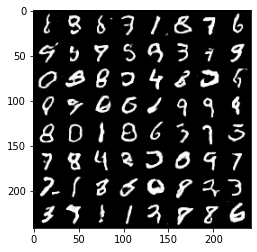

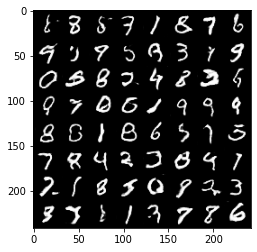

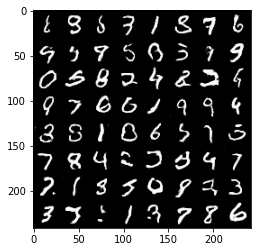

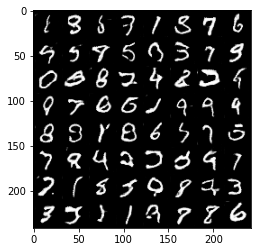

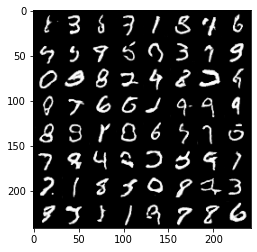

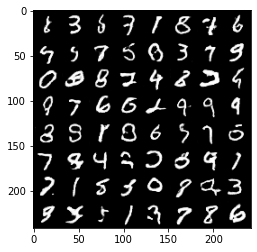

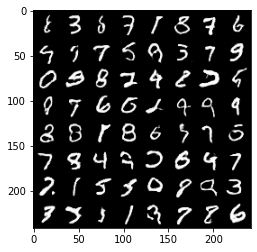

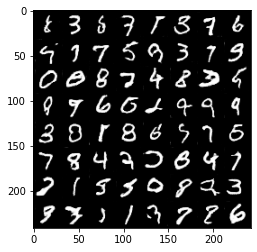

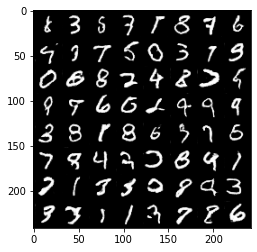

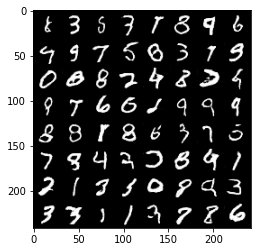

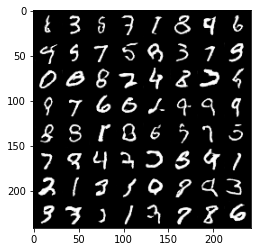

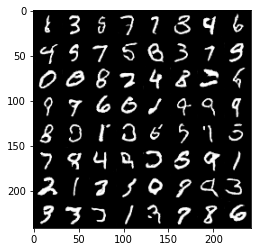

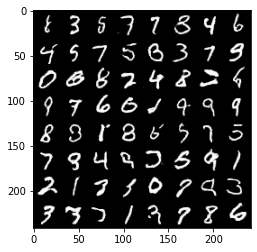

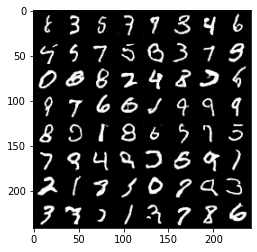

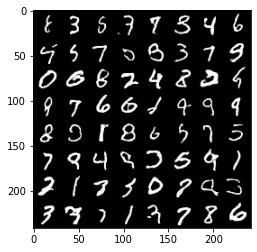

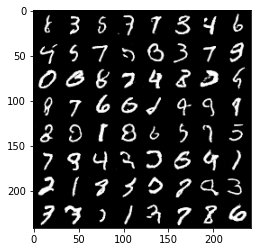

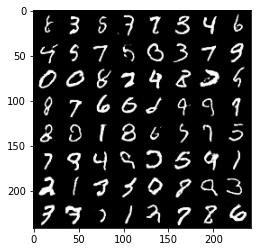

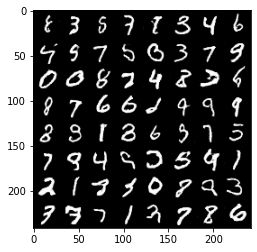

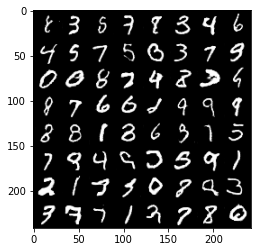

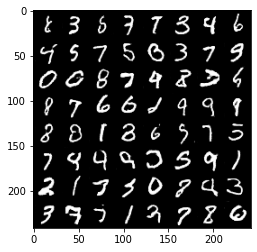

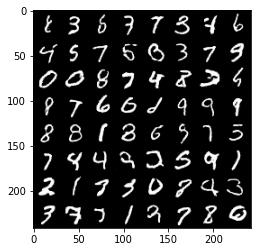

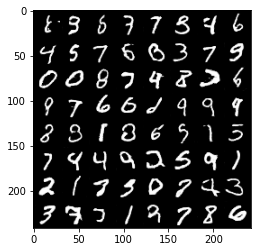

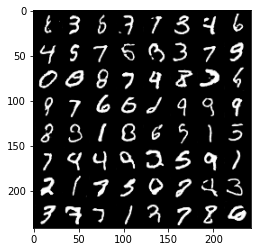

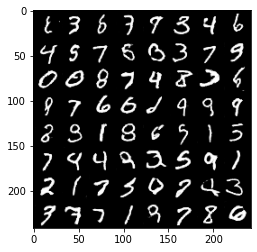

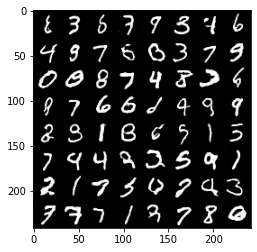

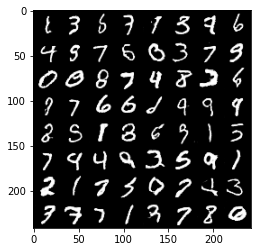

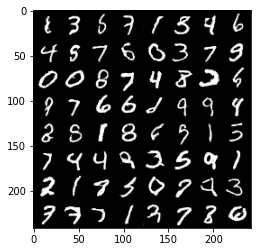

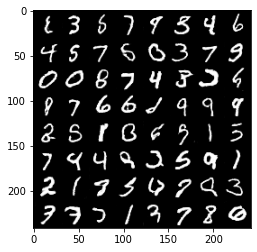

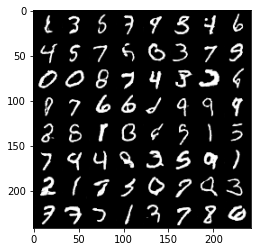

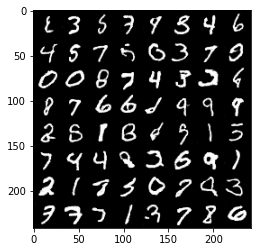

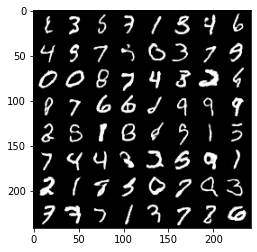

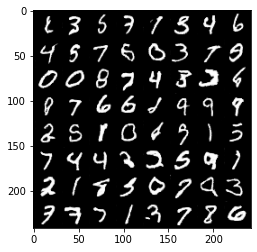

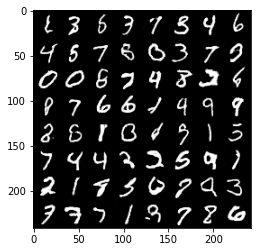

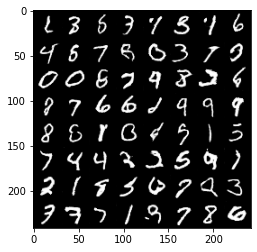

In [0]:
for image in image_list:
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()

*Generator과 Discriminator 모델에 대해 설명 좀 더 있었으면 좋겠고, 다음에 pycharm과 collab 연결 다시 해 보시고 스크린샷을 ipynb 파일에 올려 주세요*

*파일 경로에 'space'넣으지 마세요 ㅜㅜ*